In [144]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# for visualizing locations on maps
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
from cartopy.io import shapereader
import geopandas
import shapely

# predicting
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso
from sklearn.svm import SVR

## Load and match the data

In [145]:
# Load the datasets
weather_path = "../opsd-weather_data-2019-04-09/weather_data.csv"
wdf = pd.read_csv(weather_path)

ts_path = "../opsd-time_series-2019-06-05/time_series_60min_singleindex.csv"
edf = pd.read_csv(ts_path)

In [146]:
# Look for matching timestamps
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

timestamps = intersection(list(edf.utc_timestamp), list(wdf.utc_timestamp))

# Filter for only those timestamps
edf = edf[edf.utc_timestamp.isin(timestamps)]
wdf = wdf[wdf.utc_timestamp.isin(timestamps)]
edf = edf.sort_values(by='utc_timestamp')
wdf = wdf.sort_values(by='utc_timestamp')

# Only keep recent data from 2016
edf = edf.loc[edf.utc_timestamp.str.startswith("2016")]
wdf = wdf.loc[wdf.utc_timestamp.str.startswith('2016')]


In [150]:
edf.index = edf.utc_timestamp
wdf.index = wdf.utc_timestamp

In [151]:
# Get German values
wdf = wdf.filter(regex='DE_*', axis=1)
edf = edf.filter(regex='DE_*', axis=1)

In [152]:
# Remove any dates where we have NaNs in the data
keep_cols = ['DE_wind_onshore_generation_actual', 'DE_wind_offshore_generation_actual', 'DE_solar_generation_actual']
edf = edf[keep_cols]

keep_rows = edf.isnull().any(axis=1)
keep_rows = [not x for x in keep_rows]

edf = edf.loc[keep_rows]
wdf = wdf.loc[keep_rows]

In [153]:
edf.head()

,DE_wind_onshore_generation_actual,DE_wind_offshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2016-01-01T00:00:00Z,6294.0,2286.0,0.0
2016-01-01T01:00:00Z,6314.0,2229.0,0.0
2016-01-01T02:00:00Z,6431.0,2012.0,0.0
2016-01-01T03:00:00Z,6352.0,1943.0,0.0
2016-01-01T04:00:00Z,5736.0,1582.0,0.0


In [133]:
wdf.head()

,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,DE12_temperature,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
315576,3.3849,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,2.03,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0
315577,3.3636,1.965,0.0,0.0,1.73,1.84,0.0,0.0,2.50,1.90,...,0.0,0.0,4.39,2.95,0.0,0.0,3.22,0.23,0.0,0.0
315578,3.3268,1.887,0.0,0.0,1.74,1.72,0.0,0.0,2.49,1.84,...,0.0,0.0,4.12,2.82,0.0,0.0,3.36,0.27,0.0,0.0
315579,3.2796,1.885,0.0,0.0,1.73,1.82,0.0,0.0,2.38,2.01,...,0.0,0.0,4.06,2.78,0.0,0.0,3.46,0.30,0.0,0.0
315580,3.1705,1.866,0.0,0.0,1.77,1.95,0.0,0.0,2.33,2.16,...,0.0,0.0,4.18,2.80,0.0,0.0,3.47,0.24,0.0,0.0


## Exploratory plotting

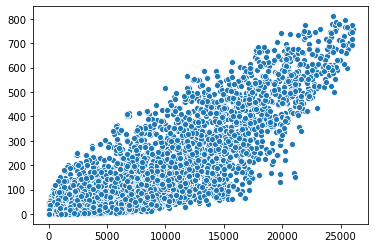

In [134]:
# Solar
sns.scatterplot(np.array(edf.DE_solar_generation_actual), np.array(wdf.DE_radiation_direct_horizontal))

In [136]:
np.corrcoef(np.array(edf.DE_solar_generation_actual), np.array(wdf.DE_radiation_direct_horizontal))

array([[1.        , 0.89268589],
       [0.89268589, 1.        ]])

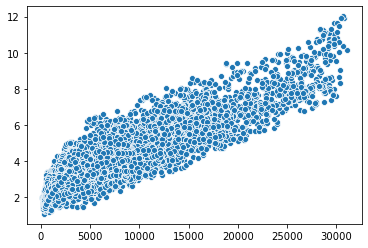

In [137]:
# Wind
sns.scatterplot(np.array(edf.DE_wind_onshore_generation_actual), np.array(wdf.DE_windspeed_10m))

In [138]:
np.corrcoef(np.array(edf.DE_wind_onshore_generation_actual), np.array(wdf.DE_windspeed_10m))

array([[1.        , 0.87639831],
       [0.87639831, 1.        ]])

# Wind prediction model

In [139]:
wind_x = wdf.copy()
wind_y = np.array(edf.copy().DE_wind_onshore_generation_actual)

wind_x = np.array(wind_x.filter(regex='windspeed_10m'))


In [140]:
model = Lasso(max_iter=5000)

model = model.fit(wind_x, wind_y)
model.score(wind_x, wind_y)

0.8685662280053741

# Solar prediction model

In [141]:
solar_x = wdf.copy()
solar_y = np.array(edf.copy().DE_solar_generation_actual)

In [142]:
model = Lasso(max_iter=5000)
model = model.fit(solar_x, solar_y)
model.score(solar_x, solar_y)

C:\Users\kevin\anaconda3\envs\green\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10777729424.562567, tolerance: 31960901.468655914
  positive)


0.9296669432042186

# Daily Plots
Make plots showing the energy production throughout a single day

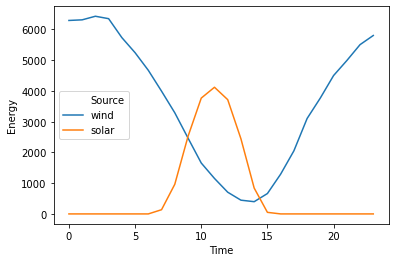

In [206]:
# Start with 01.01.2016
d = "2016-01-01"
edf_day = edf.loc[edf.index.str.startswith(d)]
wdf_day = wdf.loc[wdf.index.str.startswith(d)]

# make dataframe for that day
t = list(range(24))*2
wind = np.array(edf_day.DE_wind_onshore_generation_actual)
solar = np.array(edf_day.DE_solar_generation_actual)
energy = np.concatenate((wind, solar))
energy_type = np.array(['wind']*24 + ['solar']*24)
data = {'Energy': energy, 'Source': energy_type, 'Time': t}
df = pd.DataFrame(data)

sns.lineplot(x='Time', y='Energy', hue='Source', data=df)

In [224]:
# Use remaining data to fit linear model and generate predictions
keep_train = [not x.startswith(d) for x in list(edf.index)]
edf_train = edf.loc[keep_train]
wdf_train = wdf.loc[keep_train]

# Train wind model
wind_model = LinearRegression()
wind_x = wdf_train.copy()
wind_y = np.array(edf_train.copy().DE_wind_onshore_generation_actual)
wind_x = np.array(wind_x.filter(regex='windspeed_10m'))
wind_model.fit(wind_x, wind_y)

# Train solar model
solar_model = LinearRegression()
solar_x = np.array(wdf_train.copy())
solar_y = np.array(edf_train.copy().DE_solar_generation_actual)
solar_model.fit(solar_x, solar_y)

# Now predict for the day 'd'
x_pred_wind = wdf_day.copy()
x_pred_wind = np.array(x_pred_wind.filter(regex='windspeed_10m'))

x_pred_solar = np.array(wdf_day.copy())

pred_wind = wind_model.predict(x_pred_wind)
pred_solar = solar_model.predict(x_pred_solar)

# Set negative values to zero
pred_wind = [x if x > 0 else 0 for x in pred_wind]
pred_solar = [x if x > 0 else 0 for x in pred_solar]


In [225]:
pred_wind

[8058.086571073633,
 7472.775071385605,
 7707.633096707675,
 7430.059299056645,
 6930.633910251679,
 6067.715730932337,
 5156.654138395005,
 4362.6288107331775,
 3442.221796593337,
 3689.0450979464013,
 3043.41921167652,
 1542.6128735707798,
 28.531791929411156,
 0,
 0,
 0,
 215.6688021714399,
 1261.914351771772,
 2518.7378059017383,
 3396.7707513496107,
 4179.652048814717,
 5133.284832912855,
 5780.770895284218,
 6479.0809669028795]

In [226]:
pred_solar

[0,
 0,
 0,
 192.70048513318307,
 200.6505621805827,
 27.11628306625198,
 0,
 430.23230068707835,
 1255.459026299622,
 2272.7647680119194,
 3319.751167635752,
 3715.958662593906,
 3094.7004091965932,
 1751.4168272056672,
 0,
 0,
 0,
 90.79868414671182,
 317.9643743140268,
 301.02577914946096,
 641.4269165319956,
 619.3445096224086,
 682.7197213775339,
 672.3842174183478]

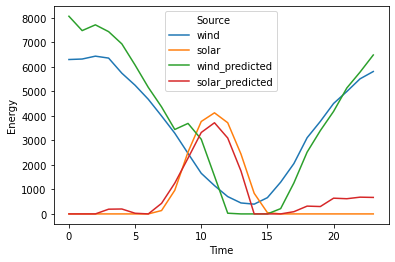

In [232]:
t = list(range(24))*4
wind = np.array(edf_day.DE_wind_onshore_generation_actual)
solar = np.array(edf_day.DE_solar_generation_actual)
energy = np.concatenate((wind, solar, pred_wind, pred_solar))
energy_type = np.array(['wind']*24 + ['solar']*24 + ['wind_predicted']*24 + ['solar_predicted']*24)
data = {'Energy': energy, 'Source': energy_type, 'Time': t}
df = pd.DataFrame(data)

sns.lineplot(x='Time', y='Energy', hue='Source', data=df, markers=True)

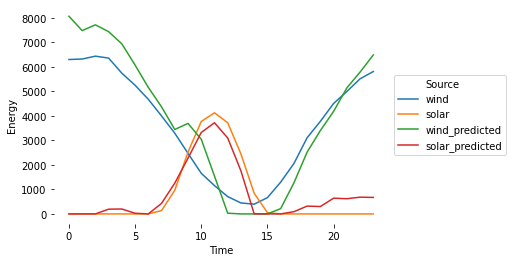

In [239]:
g = sns.lineplot(x='Time', y='Energy', hue='Source', data=df)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
sns.despine(left=True, bottom=True)